# Analysis: Supervised transfer learning with ResNet50

**Authors**: Alisa Ochs & André Schomakers

**Date**: 29.05.25

This Python notebook `.ipynb` takes the sampled _Chest X-Rays Computer Vision Project_ dataset with 584 images and we describe a knowledge discovery workflow to classify corresponding chest xray images as "normal" or "pneumonia" (supervised classification problem with binary target).   

**Research question**: Can a pre-trained ResNet50 correctly classify chest xrays with a high accuracy (>80%)? 

**Type of question**: In this case, we are dealing with a diagnostic research question. We would initially examine if a ResNet is capable of predicting pneumonia before using it in a clinic (prognostic approach).

Our approach was inspired by:
Showkat S, Qureshi S. Efficacy of Transfer Learning-based ResNet models in Chest X-ray image classification for detecting COVID-19 Pneumonia. Chemometrics and Intelligent Laboratory Systems [Internet]. 2022 Mar 10;224:104534. Available from: https://doi.org/10.1016/j.chemolab.2022.104534


## Data inspection and train-test split check-up after sampling

In [20]:
# imports
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from pathlib import Path

import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


In [5]:
# --- Configuration ---
SAMPLED_DATA_DIR = Path("/home/andre/Documents/code/AMLHC-final-exam/ChestXRay2017/chest_xray_sampled")
SEED = 42 # For consistent image selection if random is used later
random.seed(SEED)

In [7]:

# --- 1. Validate Image Counts ---

print(f"Validating image counts in: {SAMPLED_DATA_DIR.resolve()}\n")

split_dirs = ["train", "test"]
class_dirs = ["NORMAL", "PNEUMONIA"]

total_images_overall = 0

for split in split_dirs:
    split_path = SAMPLED_DATA_DIR / split
    print(f"--- {split.upper()} ---")
    if not split_path.exists():
        print(f"ERROR: Directory not found: {split_path}")
        continue
        
    total_images_in_split = 0
    for class_name in class_dirs:
        class_path = split_path / class_name
        if not class_path.exists():
            print(f"  ERROR: Directory not found: {class_path}")
            continue
            
        # Count image files (jpeg, jpg, png)
        image_extensions = ('.jpeg', '.jpg', '.png')
        # Using a generator expression with sum for efficiency
        num_images = sum(1 for f in class_path.iterdir() if f.is_file() and f.name.lower().endswith(image_extensions))
        
        print(f"  {class_name}: {num_images} images")
        total_images_in_split += num_images
    print(f"  Total in {split}: {total_images_in_split} images\n")
    total_images_overall += total_images_in_split

print(f"--- OVERALL ---")
print(f"Total images in sampled dataset: {total_images_overall} images\n")


Validating image counts in: /home/andre/Documents/code/AMLHC-final-exam/ChestXRay2017/chest_xray_sampled

--- TRAIN ---
  NORMAL: 134 images
  PNEUMONIA: 388 images
  Total in train: 522 images

--- TEST ---
  NORMAL: 23 images
  PNEUMONIA: 39 images
  Total in test: 62 images

--- OVERALL ---
Total images in sampled dataset: 584 images



The following results are the same as depicted in the `sampling_output.txt`. We can move on to a plot of both a NORMAL & PNEUMONIA image case and display their image properties, such as image height and width.

We are training our pretrained model with ~89% of the data and use ~11% for testing. $\frac{1}{10}$ of the original dataset is represented here. Within the train folder, ~25% of the images used for fine-tuning the pretrained ResNet are labelled as NORMAL images, 75% are labelled as PNEUMONIA chest xrays. We are testing on slightly different proportions of the data: ~37% of the images are labelled as NORMAL, ~63% are labelled as PNEUMONIA chest xrays.  

In [9]:
# --- 2. Plot Example Images from TRAIN set ---

train_dir = SAMPLED_DATA_DIR / "train"
normal_train_dir = train_dir / "NORMAL"
pneumonia_train_dir = train_dir / "PNEUMONIA"

# Helper to get a list of image files
def get_image_files_list(directory_path):
    image_extensions = ('.jpeg', '.jpg', '.png')
    if directory_path.exists():
        return [f for f in directory_path.iterdir() if f.is_file() and f.name.lower().endswith(image_extensions)]
    return []

In [18]:
normal_images = get_image_files_list(normal_train_dir) # list of image paths 
pneumonia_images = get_image_files_list(pneumonia_train_dir) 

# Select one image from each (if available)
normal_image_path = None
if normal_images:
    normal_image_path = random.choice(normal_images) # Option for random
else:
    print(f"No images found in {normal_train_dir}")

pneumonia_image_path = None
if pneumonia_images:
    pneumonia_image_path = random.choice(pneumonia_images) # Option for random
else:
    print(f"No images found in {pneumonia_train_dir}")

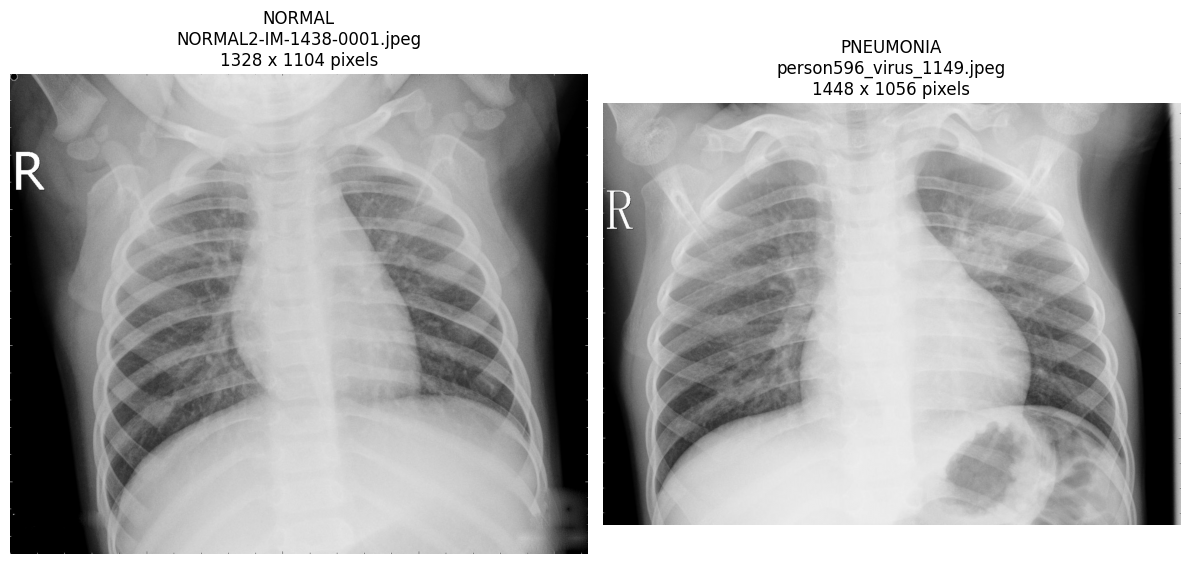

In [19]:
# Plotting
if normal_image_path and pneumonia_image_path:
    img_normal = Image.open(normal_image_path)
    img_pneumonia = Image.open(pneumonia_image_path)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # 1 row, 2 columns

    # Display NORMAL image
    axes[0].imshow(img_normal, cmap='gray' if img_normal.mode == 'L' else None) # cmap='gray' for grayscale
    axes[0].set_title(f"NORMAL\n{normal_image_path.name}\n{img_normal.width} x {img_normal.height} pixels")
    axes[0].axis('off') # Hide axes ticks

    # Display PNEUMONIA image
    axes[1].imshow(img_pneumonia, cmap='gray' if img_pneumonia.mode == 'L' else None)
    axes[1].set_title(f"PNEUMONIA\n{pneumonia_image_path.name}\n{img_pneumonia.width} x {img_pneumonia.height} pixels")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    
elif not normal_image_path:
    print("Could not display NORMAL image as none were found.")
elif not pneumonia_image_path:
    print("Could not display PNEUMONIA image as none were found.")

In the plot above, we can see two randomly sampled images from the `train` folder showcasing a NORMAL image on the left, one pathological image to the right.

Both images have different shapes and therefore Scaling is necessary, as proposed in the paper from Showkat & Qureshi (2022).

In [ ]:
sample = Image.open(normal_image_path)
sample.getbands() # images with PIL are loaded as grayscale

## Preprocessing

ResNet50 pretrained on ImageNet data works usually with 3-channeled RGB images, therefore we need three channels for image normalization (see constants below), as well 
we need a PyTorch transformation replicating the 1-channeled xray.

In [32]:
# config
TRAIN_DIR = SAMPLED_DATA_DIR / "train"
TEST_DIR = SAMPLED_DATA_DIR / "test"

# constants for PyTorch
IMG_SIZE = 224 # ResNet works pretty well with 224x224 (see paper)
BATCH_SIZE = 4 # would be bigger in reality (e.g 32)

# for normalization of the images:
NORM_MEAN = [0.5, 0.5, 0.5]
NORM_STD = [0.25, 0.25, 0.25]


In [ ]:
# HELPER fx to plot tensor:

def imshow_tensor(tensor_img, title=None):
    # PyTorch tensors are (C, H, W), Matplotlib expects (H, W, C) or (H, W)
    img = tensor_img.numpy().transpose((1, 2, 0)) # C, H, W -> H, W, C
    mean = np.array(NORM_MEAN)
    std = np.array(NORM_STD)
    img = std * img + mean # Denormalize
    img = np.clip(img, 0, 1) # Clip values to [0, 1] range for imshow
    
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [36]:
# --- 1. Define Data Preprocessing Transforms ---
# Pretrained ResNet50 models expect 3-channel RGB images.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)), # resize to 224x224
        transforms.Grayscale(num_output_channels=3), # convert grayscale to 3-channel
        transforms.ToTensor(),             # Convert PIL Image to PyTorch tensor
        transforms.Normalize(NORM_MEAN, NORM_STD) # Normalize with specified mean and std
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)), # Directly resize to 224x224
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
}


Created DataLoaders with batch size: 4
Train DataLoader: 131 batches
Test DataLoader: 16 batches

--- Verifying a sample batch from the train dataloader ---
Batch of images shape: torch.Size([4, 3, 224, 224])

Displaying the first image from the fetched batch (after preprocessing):


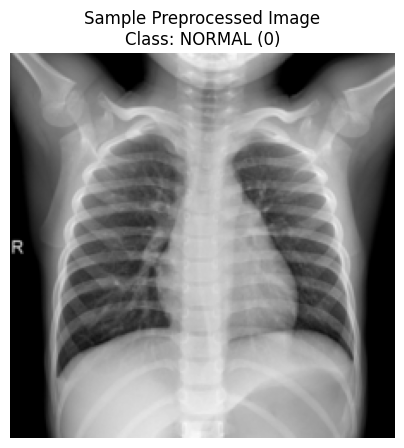

In [ ]:
# --- 2. Create PyTorch Datasets ---
# ImageFolder automatically finds class subdirs and applies transforms.
try:
    image_datasets = {
        split: ImageFolder(SAMPLED_DATA_DIR / split, data_transforms[split])
        for split in ['train', 'test']
    }

    # --- 3. Create PyTorch DataLoaders ---
    # DataLoaders provide an iterable over the dataset, handling batching and shuffling.
    dataloaders = {
        split: DataLoader(image_datasets[split], batch_size=BATCH_SIZE,
                          shuffle=(split == 'train'), num_workers=os.cpu_count() // 2 if os.cpu_count() > 1 else 0)
        for split in ['train', 'test']
    }
    print(f"\nCreated DataLoaders with batch size: {BATCH_SIZE}")
    print(f"Train DataLoader: {len(dataloaders['train'])} batches")
    print(f"Test DataLoader: {len(dataloaders['test'])} batches")

    # --- Verify a batch and inspect the transformed image ---
    print("\n--- Verifying a sample batch from the train dataloader ---")
    try:
        inputs, classes = next(iter(dataloaders['train']))
        print(f"Batch of images shape: {inputs.shape}")  # Expected: [BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE]

        # Show the first image of the batch
        if inputs.nelement() > 0: # Check if the tensor is not empty
            print("\nDisplaying the first image from the fetched batch (after preprocessing):")
            first_image_tensor = inputs[0]
            first_image_label_idx = classes[0].item()
            first_image_class_name = image_datasets['train'].classes[first_image_label_idx]
            imshow_tensor(first_image_tensor, title=f"Sample Preprocessed Image\nClass: {first_image_class_name} ({first_image_label_idx})")
        else:
            print("Fetched batch is empty. Cannot display image.")

    except StopIteration:
        print("Could not fetch a batch: The train dataloader is empty. Check if TRAIN_DIR has images.")
    except Exception as e_batch:
        print(f"Error fetching or displaying batch: {e_batch}")

except FileNotFoundError:
    print(f"ERROR: Data directory not found. Ensure '{SAMPLED_DATA_DIR}' and its subdirectories '{TRAIN_DIR}'/'{TEST_DIR}' exist and contain images.")
    print("Please run the data sampling script if you haven't already or check the SAMPLED_DATA_DIR path.")
except Exception as e_main:
    print(f"An unexpected error occurred during dataset/dataloader creation: {e_main}")
    print("Please check your data paths, directory structure, and if the directories contain valid image files.")

### Transfer learning: model training

### Transfer learning: model prediction (testing)